# Payment Date Prediction 


### Importing related Libraries 

In [640]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from datetime import datetime
from IPython.display import display 

### Store the dataset into the Dataframe


In [641]:
df = pd.read_csv('dataset.csv')

### Check the shape of the dataframe


In [642]:
df.shape

(50000, 19)

### Check the Detail information of the dataframe

In [643]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   business_code           50000 non-null  object 
 1   cust_number             50000 non-null  object 
 2   name_customer           50000 non-null  object 
 3   clear_date              40000 non-null  object 
 4   buisness_year           50000 non-null  float64
 5   doc_id                  50000 non-null  float64
 6   posting_date            50000 non-null  object 
 7   document_create_date    50000 non-null  int64  
 8   document_create_date.1  50000 non-null  int64  
 9   due_in_date             50000 non-null  float64
 10  invoice_currency        50000 non-null  object 
 11  document type           50000 non-null  object 
 12  posting_id              50000 non-null  float64
 13  area_business           0 non-null      float64
 14  total_open_amount       50000 non-null

### Display All the column names

In [644]:
df.columns

Index(['business_code', 'cust_number', 'name_customer', 'clear_date',
       'buisness_year', 'doc_id', 'posting_date', 'document_create_date',
       'document_create_date.1', 'due_in_date', 'invoice_currency',
       'document type', 'posting_id', 'area_business', 'total_open_amount',
       'baseline_create_date', 'cust_payment_terms', 'invoice_id', 'isOpen'],
      dtype='object')

### Describe the entire dataset

In [645]:
df.describe()

,buisness_year,doc_id,document_create_date,document_create_date.1,due_in_date,posting_id,area_business,total_open_amount,baseline_create_date,invoice_id,isOpen
count,50000.000000,5.000000e+04,5.000000e+04,5.000000e+04,5.000000e+04,50000.0,0.0,50000.000000,5.000000e+04,4.999400e+04,50000.000000
mean,2019.305700,2.012238e+09,2.019351e+07,2.019354e+07,2.019368e+07,1.0,NaN,32337.021651,2.019354e+07,2.011340e+09,0.200000
std,0.460708,2.885235e+08,4.496041e+03,4.482134e+03,4.470614e+03,0.0,NaN,39205.975231,4.482701e+03,2.766335e+08,0.400004
min,2019.000000,1.928502e+09,2.018123e+07,2.018123e+07,2.018122e+07,1.0,NaN,0.720000,2.018121e+07,1.928502e+09,0.000000
25%,2019.000000,1.929342e+09,2.019050e+07,2.019051e+07,2.019052e+07,1.0,NaN,4928.312500,2.019050e+07,1.929342e+09,0.000000
50%,2019.000000,1.929964e+09,2.019091e+07,2.019091e+07,2.019093e+07,1.0,NaN,17609.010000,2.019091e+07,1.929964e+09,0.000000
75%,2020.000000,1.930619e+09,2.020013e+07,2.020013e+07,2.020022e+07,1.0,NaN,47133.635000,2.020013e+07,1.930619e+09,0.000000
max,2020.000000,9.500000e+09,2.020052e+07,2.020052e+07,2.020071e+07,1.0,NaN,668593.360000,2.020052e+07,2.960636e+09,1.000000


# Data Cleaning

- Show top 5 records from the dataset

In [646]:
df.head(5)

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,0200769623,WAL-MAR corp,2020-02-11 00:00:00,2020.0,1.930438e+09,2020-01-26,20200125,20200126,20200210.0,USD,RV,1.0,NaN,54273.28,20200126.0,NAH4,1.930438e+09,0
1,U001,0200980828,BEN E,2019-08-08 00:00:00,2019.0,1.929646e+09,2019-07-22,20190722,20190722,20190811.0,USD,RV,1.0,NaN,79656.60,20190722.0,NAD1,1.929646e+09,0
2,U001,0200792734,MDV/ trust,2019-12-30 00:00:00,2019.0,1.929874e+09,2019-09-14,20190914,20190914,20190929.0,USD,RV,1.0,NaN,2253.86,20190914.0,NAA8,1.929874e+09,0
3,CA02,0140105686,SYSC llc,NaN,2020.0,2.960623e+09,2020-03-30,20200330,20200330,20200410.0,CAD,RV,1.0,NaN,3299.70,20200331.0,CA10,2.960623e+09,1
4,U001,0200769623,WAL-MAR foundation,2019-11-25 00:00:00,2019.0,1.930148e+09,2019-11-13,20191113,20191113,20191128.0,USD,RV,1.0,NaN,33133.29,20191113.0,NAH4,1.930148e+09,0


### Display the Null values percentage against every columns (compare to the total number of records)

- Output expected : area_business - 100% null, clear_data = 20% null, invoice_id = 0.12% null

In [647]:
# Calculating Null values in percentage
null_values_in_percentage = df.isnull().sum() * 100 / len(df)
null_values_in_percentage.apply(lambda x : str(x) + " % null")

business_code               0.0 % null
cust_number                 0.0 % null
name_customer               0.0 % null
clear_date                 20.0 % null
buisness_year               0.0 % null
doc_id                      0.0 % null
posting_date                0.0 % null
document_create_date        0.0 % null
document_create_date.1      0.0 % null
due_in_date                 0.0 % null
invoice_currency            0.0 % null
document type               0.0 % null
posting_id                  0.0 % null
area_business             100.0 % null
total_open_amount           0.0 % null
baseline_create_date        0.0 % null
cust_payment_terms          0.0 % null
invoice_id                0.012 % null
isOpen                      0.0 % null
dtype: object

### Display Invoice_id and Doc_Id

- Note - Many of the would have same invoice_id and doc_id


In [648]:
display(df[['invoice_id', 'doc_id']].head())
display((df['invoice_id'] == df['doc_id']).value_counts())

,invoice_id,doc_id
0,1.930438e+09,1.930438e+09
1,1.929646e+09,1.929646e+09
2,1.929874e+09,1.929874e+09
3,2.960623e+09,2.960623e+09
4,1.930148e+09,1.930148e+09


True     49994
False        6
dtype: int64

#### Write a code to check - 'baseline_create_date',"document_create_date",'document_create_date.1' - these columns are almost same.

- Please note, if they are same, we need to drop them later



In [649]:
# Checking correlation to find the similarities between the columns
# If the coefficient value lies between ± 0.50 and ± 1, then it is said to be a strong correlation
df[['baseline_create_date', 'document_create_date', 'document_create_date.1']].corr()

,baseline_create_date,document_create_date,document_create_date.1
baseline_create_date,1.000000,0.994078,0.999527
document_create_date,0.994078,1.000000,0.994547
document_create_date.1,0.999527,0.994547,1.000000


#### Please check, Column 'posting_id' is constant columns or not


In [650]:
# Checking for unique values in column to prove posting_id is constant 
df['posting_id'].unique()

array([1.])

#### Please check 'isOpen' is a constant column and relevant column for this project or not

In [651]:
"""
Checking isOpen aginst every null and not-null clear_date 

Trying to visualize for each not null and null clear_date values isOpen is 0 and 1 respectively 

isOpen can be considered as a irrelevant column for this project because clear_date 
is enough to provide the information about the invoice clearance.
"""

print('Unique valus of isOpen against nan clear_date:', end=' ')
print(np.unique([isOpen for clear_date, isOpen in zip(df['clear_date'], df['isOpen']) if str(clear_date) == 'nan']), end='\n\n')

print('Unique valus of isOpen against non-nan clear_date:', end=' ')
print(np.unique([isOpen for clear_date, isOpen in zip(df['clear_date'], df['isOpen']) if str(clear_date) != 'nan']))

Unique valus of isOpen against nan clear_date: [1]

Unique valus of isOpen against non-nan clear_date: [0]


### Write the code to drop all the following columns from the dataframe

- 'area_business'
- "posting_id"
- "invoice_id"
- "document_create_date"
- "isOpen"
- 'document type' 
- 'document_create_date.1

In [652]:
# Creating a deep copy of the original dataframe
df_copy = copy.deepcopy(df)

# Removing above columns
columns_to_remove = ['area_business', 'posting_id', 'invoice_id', 'document_create_date', 'isOpen', 'document type', 'document_create_date.1']
df_copy.drop(columns_to_remove, axis = 1, inplace = True)

### Please check from the dataframe whether all the columns are removed or not 

In [653]:
# Intersection of original dataframe and new dataframe columns will give the set of dropped columns
set(df.columns) - set(df_copy.columns)

{'area_business',
 'document type',
 'document_create_date',
 'document_create_date.1',
 'invoice_id',
 'isOpen',
 'posting_id'}

### Show all the Duplicate rows from the dataframe

In [654]:
df_copy[df_copy.duplicated()]

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,invoice_currency,total_open_amount,baseline_create_date,cust_payment_terms
1041,U001,0200769623,WAL-MAR in,2019-03-12 00:00:00,2019.0,1.928870e+09,2019-02-28,20190315.0,USD,19557.41,20190228.0,NAH4
2400,U001,0200769623,WAL-MAR trust,2019-08-28 00:00:00,2019.0,1.929758e+09,2019-08-18,20190902.0,USD,5600.41,20190818.0,NAH4
2584,U001,0200769623,WAL-MAR corporation,2019-12-16 00:00:00,2019.0,1.930217e+09,2019-12-04,20191219.0,USD,35352.17,20191204.0,NAH4
3755,U001,0200769623,WAL-MAR,2019-11-22 00:00:00,2019.0,1.930137e+09,2019-11-12,20191127.0,USD,2982.64,20191112.0,NAH4
3873,CA02,0140104409,LOB associates,NaN,2020.0,2.960629e+09,2020-04-14,20200425.0,CAD,82975.82,20200415.0,CA10
...,...,...,...,...,...,...,...,...,...,...,...,...
49928,U001,0200915438,GROC trust,2019-08-15 00:00:00,2019.0,1.929646e+09,2019-07-25,20190809.0,USD,6969.00,20190725.0,NAA8
49963,U001,0200759878,SA us,2019-01-29 00:00:00,2019.0,1.928614e+09,2019-01-13,20190128.0,USD,10968.24,20190113.0,NAH4
49986,U001,0200772670,ASSOCIAT foundation,2019-06-12 00:00:00,2019.0,1.929403e+09,2019-05-29,20190613.0,USD,155837.53,20190529.0,NAU5
49990,U001,0200765011,MAINES llc,2019-06-06 00:00:00,2019.0,1.929365e+09,2019-05-22,20190606.0,USD,4008.05,20190522.0,NAA8


### Display the Number of Duplicate Rows

In [655]:
df_copy.duplicated().sum()

1161

### Drop all the Duplicate Rows

In [656]:
# Dropping dubplicated rows
df_copy.drop_duplicates(keep="first", inplace=True)

#### Now check for all duplicate rows now



- Note - It must be 0 by now

In [657]:
len(df_copy[df_copy.duplicated()])

0

### Check for the number of Rows and Columns in your dataset

In [658]:
df_copy.shape

(48839, 12)

### Find out the total count of null values in each columns

In [659]:
df_copy.isnull().sum()

business_code              0
cust_number                0
name_customer              0
clear_date              9681
buisness_year              0
doc_id                     0
posting_date               0
due_in_date                0
invoice_currency           0
total_open_amount          0
baseline_create_date       0
cust_payment_terms         0
dtype: int64

#Data type Conversion 

### Please check the data type of each column of the dataframe

In [660]:
df_copy.dtypes

business_code            object
cust_number              object
name_customer            object
clear_date               object
buisness_year           float64
doc_id                  float64
posting_date             object
due_in_date             float64
invoice_currency         object
total_open_amount       float64
baseline_create_date    float64
cust_payment_terms       object
dtype: object

### Check the datatype format of below columns

- clear_date  
- posting_date
- due_in_date 
- baseline_create_date

In [661]:
df_copy[['clear_date', 'posting_date', 'due_in_date', 'baseline_create_date']].dtypes

clear_date               object
posting_date             object
due_in_date             float64
baseline_create_date    float64
dtype: object

### converting date columns into date time formats

- clear_date  
- posting_date
- due_in_date 
- baseline_create_date


- **Note - You have to convert all these above columns into "%Y%m%d" format**

In [662]:
# Converting columns to "%Y%m%d" format

def converting_datetime(df_temp, column, format_str, converter_func):
    df_temp[column] = df_temp[column].apply(lambda x: datetime.strptime(converter_func(x), format_str) if str(x) != 'nan' else np.nan)

float_to_str = lambda x: str(int(x))
int_to_str = lambda x: str(x)
time_str = lambda x: str(x)[:10]

converting_datetime(df_copy, 'due_in_date', '%Y%m%d', float_to_str)
converting_datetime(df_copy, 'baseline_create_date', '%Y%m%d', float_to_str)
converting_datetime(df_copy, 'clear_date', '%Y-%m-%d', time_str)

temp_list = ['clear_date', 'posting_date', 'due_in_date', 'baseline_create_date']

for i in temp_list:
  df_copy[i] = pd.to_datetime(df_copy[i], format='%Y-%m-%d')

### Please check the datatype of all the columns after conversion of the above 4 columns

In [663]:
df_copy[['clear_date', 'posting_date', 'due_in_date', 'baseline_create_date']].dtypes

clear_date              datetime64[ns]
posting_date            datetime64[ns]
due_in_date             datetime64[ns]
baseline_create_date    datetime64[ns]
dtype: object

#### the invoice_currency column contains two different categories, USD and CAD

- Please do a count of each currency 

In [664]:
df_copy['invoice_currency'].value_counts()

USD    45011
CAD     3828
Name: invoice_currency, dtype: int64

#### display the "total_open_amount" column value

In [665]:
df_copy['total_open_amount']

0        54273.28
1        79656.60
2         2253.86
3         3299.70
4        33133.29
           ...   
49995     3187.86
49996     6766.54
49997     6120.86
49998       63.48
49999     1790.30
Name: total_open_amount, Length: 48839, dtype: float64

### Convert all CAD into USD currency of "total_open_amount" column

- 1 CAD = 0.7 USD
- Create a new column i.e "converted_usd" and store USD and convered CAD to USD

In [666]:
# Creating an empty list to store the converted 'total_open_amount'
amount_list = list()

for amount, currency in zip(df_copy['total_open_amount'], df_copy['invoice_currency']):
  if currency == 'CAD':
    amount_list.append(0.7*amount)
  else:
    amount_list.append(amount)

# Setting the values to new column 'converted_usd'
df_copy['converted_usd'] = pd.Series(amount_list, index=df_copy.index)


### Display the new "converted_usd" column values

In [667]:
df_copy['converted_usd']

0        54273.28
1        79656.60
2         2253.86
3         2309.79
4        33133.29
           ...   
49995     3187.86
49996     6766.54
49997     6120.86
49998       63.48
49999     1790.30
Name: converted_usd, Length: 48839, dtype: float64

### Display year wise total number of record 

- Note -  use "buisness_year" column for this 

In [668]:
df['buisness_year'].value_counts()

2019.0    34715
2020.0    15285
Name: buisness_year, dtype: int64

### Write the code to delete the following columns 

- 'invoice_currency'
- 'total_open_amount', 

In [669]:
df_copy.drop(['invoice_currency', 'total_open_amount'], axis = 1, inplace = True)

### Write a code to check the number of columns in dataframe

In [670]:
len(df_copy.columns)

11

# Splitting the Dataset 

### Look for all columns containing null value

- Note - Output expected is only one column 

In [671]:
df_copy.isnull().sum()

business_code              0
cust_number                0
name_customer              0
clear_date              9681
buisness_year              0
doc_id                     0
posting_date               0
due_in_date                0
baseline_create_date       0
cust_payment_terms         0
converted_usd              0
dtype: int64

#### Find out the number of null values from the column that you got from the above code

In [672]:
df_copy['clear_date'].isnull().sum()

9681

### On basis of the above column we are spliting data into dataset

- First dataframe (refer that as maindata) only containing the rows, that have NO NULL data in that column ( This is going to be our train dataset ) 
- Second dataframe (refer that as nulldata) that contains the columns, that have Null data in that column ( This is going to be our test dataset ) 

In [673]:
maindata = copy.deepcopy(df_copy[df_copy['clear_date'].notnull()])
nulldata = copy.deepcopy(df_copy[df_copy['clear_date'].isnull()])

### Check the number of Rows and Columns for both the dataframes 

In [674]:
maindata.shape

(39158, 11)

In [675]:
nulldata.shape

(9681, 11)

### Display the 5 records from maindata and nulldata dataframes

In [676]:
maindata.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd
0,U001,0200769623,WAL-MAR corp,2020-02-11,2020.0,1.930438e+09,2020-01-26,2020-02-10,2020-01-26,NAH4,54273.280
1,U001,0200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-08-11,2019-07-22,NAD1,79656.600
2,U001,0200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-29,2019-09-14,NAA8,2253.860
4,U001,0200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-28,2019-11-13,NAH4,33133.290
5,CA02,0140106181,THE corporation,2019-12-04,2019.0,2.960581e+09,2019-09-20,2019-10-04,2019-09-24,CA10,15558.088


In [677]:
nulldata.head()

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd
3,CA02,0140105686,SYSC llc,NaT,2020.0,2.960623e+09,2020-03-30,2020-04-10,2020-03-31,CA10,2309.79
7,U001,0200744019,TARG us,NaT,2020.0,1.930659e+09,2020-03-19,2020-04-03,2020-03-19,NAA8,11173.02
10,U001,0200418007,AM,NaT,2020.0,1.930611e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,3525.59
14,U001,0200739534,OK systems,NaT,2020.0,1.930788e+09,2020-04-15,2020-04-30,2020-04-15,NAA8,121105.65
15,U001,0200353024,DECA corporation,NaT,2020.0,1.930817e+09,2020-04-23,2020-04-26,2020-04-16,NAM2,3726.06


## Considering the **maindata**

#### Generate a new column "Delay" from the existing columns

- Note - You are expected to create a new column 'Delay' from two existing columns, "clear_date" and "due_in_date" 
- Formula - Delay = clear_date - due_in_date

In [678]:
maindata['Delay'] = maindata['clear_date'] - maindata['due_in_date']

### Generate a new column "avgdelay" from the existing columns

- Note - You are expected to make a new column "avgdelay" by grouping "name_customer" column with reapect to mean of the "Delay" column.
- This new column "avg_delay" is meant to store "customer_name" wise delay
- groupby('name_customer')['Delay'].mean(numeric_only=False)
- Display the new "avg_delay" column

In [679]:
df_temp = maindata.groupby('name_customer')['Delay'].mean(numeric_only=False)
df_temp

name_customer
11078 us                 17 days 00:00:00
17135 associates       -10 days +00:00:00
17135 llc               -3 days +00:00:00
236008 associates       -3 days +00:00:00
99 CE                     2 days 00:00:00
                              ...        
YEN BROS corp             0 days 00:00:00
YEN BROS corporation    -1 days +12:00:00
YEN BROS llc            -2 days +00:00:00
ZARCO co                -1 days +00:00:00
ZIYAD  us                 6 days 00:00:00
Name: Delay, Length: 3889, dtype: timedelta64[ns]

You need to add the "avg_delay" column with the maindata, mapped with "name_customer" column

 - Note - You need to use map function to map the avgdelay with respect to "name_customer" column

In [680]:
# Creating an empty list to store average delay value against their name_customer
temp_list = list()
maindata['name_customer'].map(lambda x: temp_list.append(df_temp[x]))

# Setting values to new column 'avg_delay'
maindata['avg_delay'] = pd.Series(temp_list, index = maindata.index)

### Observe that the "avg_delay" column is in days format. You need to change the format into seconds

- Days_format :  17 days 00:00:00
- Format in seconds : 1641600.0

In [681]:
maindata['avg_delay'] = maindata['avg_delay'].dt.total_seconds()

### Display the maindata dataframe 

In [682]:
maindata

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd,Delay,avg_delay
0,U001,0200769623,WAL-MAR corp,2020-02-11,2020.0,1.930438e+09,2020-01-26,2020-02-10,2020-01-26,NAH4,54273.280,1 days,-2.334702e+05
1,U001,0200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-08-11,2019-07-22,NAD1,79656.600,-3 days,1.641600e+06
2,U001,0200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-29,2019-09-14,NAA8,2253.860,92 days,6.990545e+05
4,U001,0200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-28,2019-11-13,NAH4,33133.290,-3 days,-1.887923e+05
5,CA02,0140106181,THE corporation,2019-12-04,2019.0,2.960581e+09,2019-09-20,2019-10-04,2019-09-24,CA10,15558.088,61 days,6.172800e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49994,U001,0200762301,C&S WH trust,2019-07-25,2019.0,1.929601e+09,2019-07-10,2019-07-25,2019-07-10,NAC6,84780.400,0 days,-3.330000e+04
49996,U001,0200769623,WAL-MAR co,2019-09-03,2019.0,1.929744e+09,2019-08-15,2019-08-30,2019-08-15,NAH4,6766.540,4 days,-2.135915e+05
49997,U001,0200772595,SAFEW associates,2020-03-05,2020.0,1.930537e+09,2020-02-19,2020-03-05,2020-02-19,NAA8,6120.860,0 days,9.051429e+04
49998,U001,0200726979,BJ'S llc,2019-12-12,2019.0,1.930199e+09,2019-11-27,2019-12-12,2019-11-27,NAA8,63.480,0 days,1.354030e+05


### Since you have created the "avg_delay" column from "Delay" and "clear_date" column, there is no need of these two columns anymore 

- You are expected to drop "Delay" and "clear_date" columns from maindata dataframe 

In [683]:
maindata.drop(['Delay', 'clear_date'], axis = 1, inplace = True)

# Splitting of Train and the Test Data

### You need to split the "maindata" columns into X and y dataframe

- Note - y should have the target column i.e. "avg_delay" and the other column should be in X

- X is going to hold the source fields and y will be going to hold the target fields

In [684]:
from sklearn.model_selection import train_test_split

# Columns for X set
X_columns = list(set(maindata.columns) - set(['avg_delay']))
X = maindata[X_columns]

In [685]:
# y with target field
y = maindata['avg_delay']

#### You are expected to split both the dataframes into train and test format in 60:40 ratio 

- Note - The expected output should be in "X_train", "X_loc_test", "y_train", "y_loc_test" format 

In [686]:
X_train, X_loc_test, y_train, y_loc_test = train_test_split(X, y, test_size=0.4, random_state=0)

### Please check for the number of rows and columns of all the new dataframes (all 4)

In [687]:
print(X_train.shape)
print(X_loc_test.shape)
print(y_train.shape)
print(y_loc_test.shape)

(23494, 10)
(15664, 10)
(23494,)
(15664,)


### Now you are expected to split the "X_loc_test" and "y_loc_test" dataset into "Test" and "Validation" (as the names given below) dataframe with 50:50 format 

- Note - The expected output should be in "X_val", "X_test", "y_val", "y_test" format

In [688]:
X_val, X_test, y_val, y_test = train_test_split(X_loc_test, y_loc_test, test_size=0.5, random_state=0)

### Please check for the number of rows and columns of all the 4 dataframes 

In [689]:
print(X_val.shape)
print(X_test.shape)
print(y_val.shape)
print(y_test.shape)

(7832, 10)
(7832, 10)
(7832,)
(7832,)


# Exploratory Data Analysis (EDA) 

### Distribution Plot of the target variable (use the dataframe which contains the target field)

- Note - You are expected to make a distribution plot for the target variable 

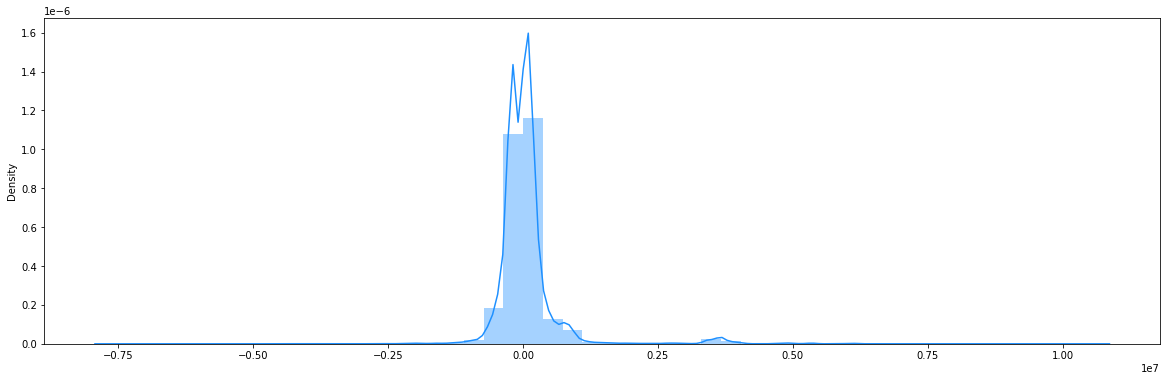

In [690]:
import warnings
warnings.filterwarnings('ignore')

fig_dims = (20, 6)
fig, axs = plt.subplots(figsize=fig_dims)
sns.distplot(x=y, color="dodgerblue", ax=axs)

### You are expected to group the X_train dataset on 'name_customer' column with 'doc_id' in the x_train set

### Need to store the outcome into a new dataframe 

- Note code given for groupby statement- X_train.groupby(by=['name_customer'], as_index=False)['doc_id'].count()

In [691]:
x_train = X_train.groupby(by=['name_customer'], as_index=False)['doc_id'].count()

### You can make another distribution plot of the "doc_id" column from x_train

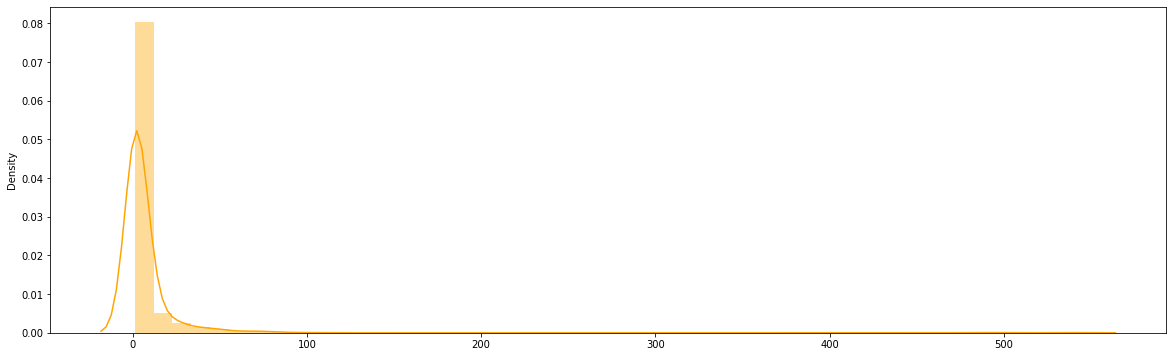

In [692]:
fig, axs = plt.subplots(figsize=fig_dims)
sns.distplot(x=x_train['doc_id'], color="orange", ax=axs)

#### Create a Distribution plot only for business_year and a seperate distribution plot of "business_year" column along with the doc_id" column


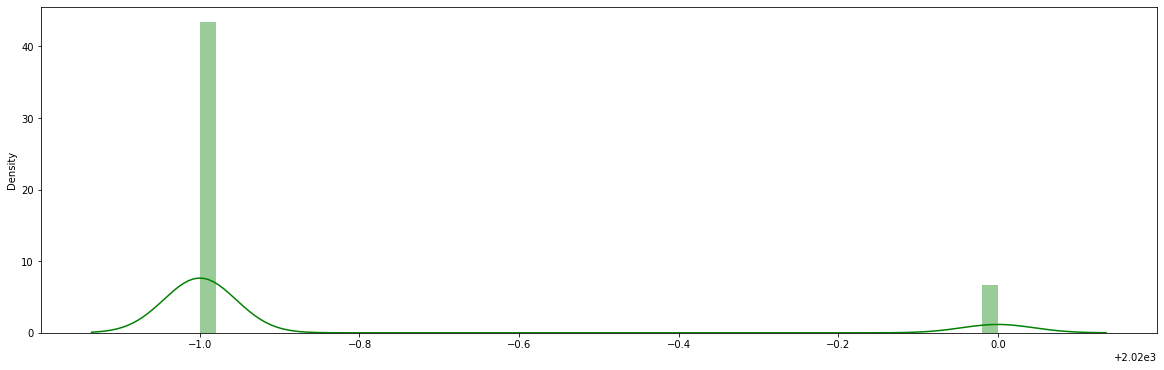

In [693]:
fig, axs = plt.subplots(figsize=fig_dims)
sns.distplot(x=X_train['buisness_year'], color='green', ax=axs)

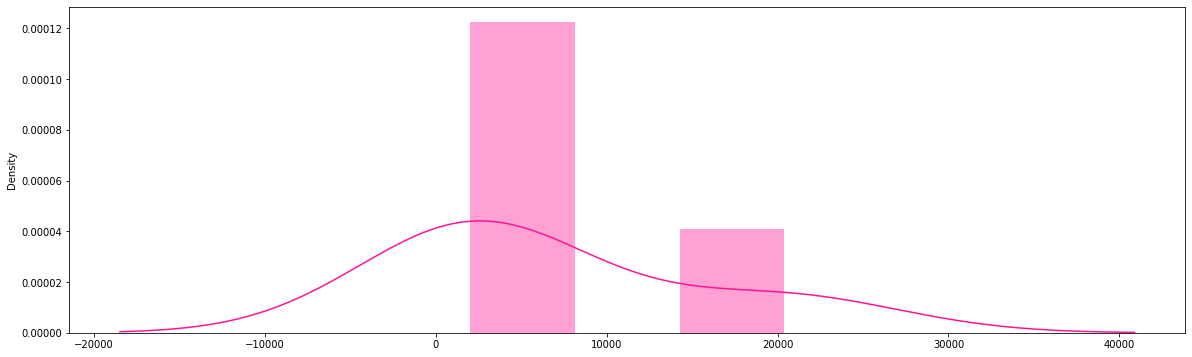

In [694]:
plot_new = X_train.groupby(by=['buisness_year'], as_index=False)['doc_id'].count()
fig, axs = plt.subplots(figsize=fig_dims)
sns.distplot(x=plot_new, ax=axs, color='deeppink')

# Feature Engineering 

### Display and describe the X_train dataframe 

In [695]:
X_train

,converted_usd,buisness_year,cust_payment_terms,posting_date,business_code,name_customer,doc_id,due_in_date,cust_number,baseline_create_date
45718,36273.03,2020.0,NAAX,2020-01-28,U001,COST foundation,1.930448e+09,2020-02-12,0200794332,2020-01-28
17966,6349.27,2020.0,NAA8,2020-02-13,U001,WINC trust,1.930517e+09,2020-02-28,0200706844,2020-02-13
21322,282.84,2019.0,NAM4,2019-01-08,U001,DEC us,1.928590e+09,2019-01-24,0200803720,2019-01-01
38919,64749.18,2020.0,NAA8,2020-02-12,U001,KROGER,1.930509e+09,2020-02-27,0200752302,2020-02-12
25191,2066.63,2019.0,NAA8,2019-06-12,U001,RESTA co,1.929483e+09,2019-06-27,0200974851,2019-06-12
...,...,...,...,...,...,...,...,...,...,...
26152,3449.63,2019.0,NAH4,2019-11-14,U001,WAL-MAR associates,1.930152e+09,2019-11-29,0200769623,2019-11-14
40790,40591.75,2019.0,NAA8,2019-12-06,U001,SUPE in,1.930222e+09,2019-12-21,0200793568,2019-12-06
38558,24869.32,2019.0,NAA8,2019-04-22,U001,GROC associates,1.929175e+09,2019-05-07,0100036066,2019-04-22
26776,42362.89,2019.0,NAH4,2019-06-28,U001,WAL-MAR associates,1.929555e+09,2019-07-13,200769623,2019-06-28


In [696]:
X_train.describe()

,converted_usd,buisness_year,doc_id
count,23494.000000,23494.000000,2.349400e+04
mean,30999.755826,2019.132247,2.014021e+09
std,36630.432880,0.338766,2.956842e+08
min,4.380000,2019.000000,1.928502e+09
25%,4622.179500,2019.000000,1.929174e+09
50%,16919.885000,2019.000000,1.929731e+09
75%,45911.302500,2019.000000,1.930209e+09
max,632134.240000,2020.000000,9.500000e+09


#### The "business_code" column inside X_train, is a categorical column, so you need to perform Labelencoder on that particular column

- Note - call the Label Encoder from sklearn library and use the fit() function on "business_code" column
- Note - Please fill in the blanks (two) to complete this code

In [697]:
from sklearn.preprocessing import LabelEncoder
business_coder = LabelEncoder()
business_coder.fit(X_train['business_code'])

LabelEncoder()

#### You are expected to store the value into a new column i.e. "business_code_enc"

- Note - For Training set you are expected to use fit_trainsform()
- Note - For Test set you are expected to use the trainsform()
- Note - For Validation set you are expected to use the trainsform()


- Partial code is provided, please fill in the blanks 

In [698]:
X_train['business_code_enc'] = business_coder.fit_transform(X_train['business_code'])

In [699]:
X_val['business_code_enc'] = business_coder.transform(X_val['business_code'])
X_test['business_code_enc'] = business_coder.transform(X_test['business_code'])

### Display "business_code" and "business_code_enc" together from X_train dataframe 

In [700]:
X_train[['business_code', 'business_code_enc']]

,business_code,business_code_enc
45718,U001,1
17966,U001,1
21322,U001,1
38919,U001,1
25191,U001,1
...,...,...
26152,U001,1
40790,U001,1
38558,U001,1
26776,U001,1


#### Create a function called "custom" for dropping the columns 'business_code' from train, test and validation dataframe

- Note - Fill in the blank to complete the code

In [701]:
def custom(col ,traindf = X_train,valdf = X_val,testdf = X_test):
    traindf.drop(col, axis =1,inplace=True)
    valdf.drop(col,axis=1 , inplace=True)
    testdf.drop(col,axis=1 , inplace=True)

    return traindf,valdf ,testdf

### Call the function by passing the column name which needed to be dropped from train, test and validation dataframes. Return updated dataframes to be stored in X_train ,X_val, X_test  

- Note = Fill in the blank to complete the code 

In [702]:
X_train , X_val , X_test = custom(['business_code'])

### Manually replacing str values with numbers, Here we are trying manually replace the customer numbers with some specific values like, 'CCCA' as 1, 'CCU' as 2 and so on. Also we are converting the datatype "cust_number" field to int type.

- We are doing it for all the three dataframes as shown below. This is fully completed code. No need to modify anything here 



In [703]:
X_train['cust_number'] = X_train['cust_number'].str.replace('CCCA',"1").str.replace('CCU',"2").str.replace('CC',"3").astype(int)
X_test['cust_number'] = X_test['cust_number'].str.replace('CCCA',"1").str.replace('CCU',"2").str.replace('CC',"3").astype(int)
X_val['cust_number'] = X_val['cust_number'].str.replace('CCCA',"1").str.replace('CCU',"2").str.replace('CC',"3").astype(int)


#### It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]. Unknown will be added in fit and transform will take care of new item. It gives unknown class id.

#### This will fit the encoder for all the unique values and introduce unknown value

- Note - Keep this code as it is, we will be using this later on.  

In [704]:
#For encoding unseen labels
class EncoderExt(object):
    def __init__(self):
        self.label_encoder = LabelEncoder()
    def fit(self, data_list):
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_
        return self
    def transform(self, data_list):
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]
        return self.label_encoder.transform(new_data_list)

### Use the user define Label Encoder function called "EncoderExt" for the "name_customer" column

- Note - Keep the code as it is, no need to change

In [705]:
label_encoder = EncoderExt()
label_encoder.fit(X_train['name_customer'])
X_train['name_customer_enc']=label_encoder.transform(X_train['name_customer'])
X_val['name_customer_enc']=label_encoder.transform(X_val['name_customer'])
X_test['name_customer_enc']=label_encoder.transform(X_test['name_customer'])

### As we have created the a new column "name_customer_enc", so now drop "name_customer" column from all three dataframes

- Note - Keep the code as it is, no need to change

In [706]:
X_train ,X_val, X_test = custom(['name_customer'])

### Using Label Encoder for the "cust_payment_terms" column

- Note - Keep the code as it is, no need to change

In [707]:
label_encoder1 = EncoderExt()
label_encoder1.fit(X_train['cust_payment_terms'])
X_train['cust_payment_terms_enc']=label_encoder1.transform(X_train['cust_payment_terms'])
X_val['cust_payment_terms_enc']=label_encoder1.transform(X_val['cust_payment_terms'])
X_test['cust_payment_terms_enc']=label_encoder1.transform(X_test['cust_payment_terms'])

In [708]:
X_train ,X_val, X_test = custom(['cust_payment_terms'])

## Check the datatype of all the columns of Train, Test and Validation dataframes realted to X

- Note - You are expected yo use dtype

In [709]:
X_train.dtypes

converted_usd                    float64
buisness_year                    float64
posting_date              datetime64[ns]
doc_id                           float64
due_in_date               datetime64[ns]
cust_number                        int64
baseline_create_date      datetime64[ns]
business_code_enc                  int64
name_customer_enc                  int64
cust_payment_terms_enc             int64
dtype: object

In [710]:
X_val.dtypes

converted_usd                    float64
buisness_year                    float64
posting_date              datetime64[ns]
doc_id                           float64
due_in_date               datetime64[ns]
cust_number                        int64
baseline_create_date      datetime64[ns]
business_code_enc                  int64
name_customer_enc                  int64
cust_payment_terms_enc             int64
dtype: object

In [711]:
X_test.dtypes

converted_usd                    float64
buisness_year                    float64
posting_date              datetime64[ns]
doc_id                           float64
due_in_date               datetime64[ns]
cust_number                        int64
baseline_create_date      datetime64[ns]
business_code_enc                  int64
name_customer_enc                  int64
cust_payment_terms_enc             int64
dtype: object

### From the above output you can notice their are multiple date columns with datetime format

### In order to pass it into our model, we need to convert it into float format

### You need to extract day, month and year from the "posting_date" column 

1.   Extract days from "posting_date" column and store it into a new column "day_of_postingdate" for train, test and validation dataset 
2.   Extract months from "posting_date" column and store it into a new column "month_of_postingdate" for train, test and validation dataset
3.   Extract year from "posting_date" column and store it into a new column "year_of_postingdate" for train, test and validation dataset 



- Note - You are supposed yo use 

*   dt.day
*   dt.month
*   dt.year






In [712]:
X_train['day_of_postingdate'] = X_train['posting_date'].dt.day
X_train['month_of_postingdate'] = X_train['posting_date'].dt.month
X_train['year_of_postingdate'] = X_train['posting_date'].dt.year

X_val['day_of_postingdate'] = X_val['posting_date'].dt.day
X_val['month_of_postingdate'] = X_val['posting_date'].dt.month
X_val['year_of_postingdate'] = X_val['posting_date'].dt.year

X_test['day_of_postingdate'] = X_test['posting_date'].dt.day
X_test['month_of_postingdate'] = X_test['posting_date'].dt.month
X_test['year_of_postingdate'] = X_test['posting_date'].dt.year

### pass the "posting_date" column into the Custom function for train, test and validation dataset

In [713]:
X_train ,X_val, X_test = custom(['posting_date'])

### You need to extract day, month and year from the "baseline_create_date" column 

1.   Extract days from "baseline_create_date" column and store it into a new column "day_of_createdate" for train, test and validation dataset 
2.   Extract months from "baseline_create_date" column and store it into a new column "month_of_createdate" for train, test and validation dataset
3.   Extract year from "baseline_create_date" column and store it into a new column "year_of_createdate" for train, test and validation dataset 



- Note - You are supposed yo use 

*   dt.day
*   dt.month
*   dt.year


- Note - Do as it is been shown in the previous two code boxes

### Extracting Day, Month, Year for 'baseline_create_date' column

In [714]:
X_train['day_of_createdate'] = X_train['baseline_create_date'].dt.day
X_train['month_of_createdate'] = X_train['baseline_create_date'].dt.month
X_train['year_of_createdate'] = X_train['baseline_create_date'].dt.year

X_val['day_of_createdate'] = X_val['baseline_create_date'].dt.day
X_val['month_of_createdate'] = X_val['baseline_create_date'].dt.month
X_val['year_of_createdate'] = X_val['baseline_create_date'].dt.year

X_test['day_of_createdate'] = X_test['baseline_create_date'].dt.day
X_test['month_of_createdate'] = X_test['baseline_create_date'].dt.month
X_test['year_of_createdate'] = X_test['baseline_create_date'].dt.year

### pass the "baseline_create_date" column into the Custom function for train, test and validation dataset

In [715]:
X_train ,X_val, X_test = custom(['baseline_create_date'])

### You need to extract day, month and year from the "due_in_date" column 

1.   Extract days from "due_in_date" column and store it into a new column "day_of_due" for train, test and validation dataset 
2.   Extract months from "due_in_date" column and store it into a new column "month_of_due" for train, test and validation dataset
3.   Extract year from "due_in_date" column and store it into a new column "year_of_due" for train, test and validation dataset 



- Note - You are supposed yo use 

*   dt.day
*   dt.month
*   dt.year

- Note - Do as it is been shown in the previous code

In [716]:
X_train['day_of_due'] = X_train['due_in_date'].dt.day
X_train['month_of_due'] = X_train['due_in_date'].dt.month
X_train['year_of_due'] = X_train['due_in_date'].dt.year

X_val['day_of_due'] = X_val['due_in_date'].dt.day
X_val['month_of_due'] = X_val['due_in_date'].dt.month
X_val['year_of_due'] = X_val['due_in_date'].dt.year

X_test['day_of_due'] = X_test['due_in_date'].dt.day
X_test['month_of_due'] = X_test['due_in_date'].dt.month
X_test['year_of_due'] = X_test['due_in_date'].dt.year

pass the "due_in_date" column into the Custom function for train, test and validation dataset

In [717]:
X_train ,X_val, X_test = custom(['due_in_date'])

### Check for the datatypes for train, test and validation set again

- Note - all the data type should be in either int64 or float64 format 


In [718]:
print('X_train.dtypes\n' + '-'*15 + '\n')
print(X_train.dtypes)

print('\n\nX_val.dtypes\n' + '-'*15 + '\n')
print(X_val.dtypes)

print('\n\nX_test.dtypes\n' + '-'*15 + '\n')
print(X_test.dtypes)

X_train.dtypes
---------------

converted_usd             float64
buisness_year             float64
doc_id                    float64
cust_number                 int64
business_code_enc           int64
name_customer_enc           int64
cust_payment_terms_enc      int64
day_of_postingdate          int64
month_of_postingdate        int64
year_of_postingdate         int64
day_of_createdate           int64
month_of_createdate         int64
year_of_createdate          int64
day_of_due                  int64
month_of_due                int64
year_of_due                 int64
dtype: object


X_val.dtypes
---------------

converted_usd             float64
buisness_year             float64
doc_id                    float64
cust_number                 int64
business_code_enc           int64
name_customer_enc           int64
cust_payment_terms_enc      int64
day_of_postingdate          int64
month_of_postingdate        int64
year_of_postingdate         int64
day_of_createdate           int64
mont

# Feature Selection

### Filter Method

- Calling the VarianceThreshold Function 
- Note - Keep the code as it is, no need to change 

In [719]:
from sklearn.feature_selection import VarianceThreshold
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(X_train)
len(X_train.columns[constant_filter.get_support()])

16

- Note - Keep the code as it is, no need to change 


In [720]:
constant_columns = [column for column in X_train.columns
                    if column not in X_train.columns[constant_filter.get_support()]]
print(len(constant_columns))

0


- transpose the feature matrice
- print the number of duplicated features
- select the duplicated features columns names

- Note - Keep the code as it is, no need to change 


In [721]:
x_train_T = X_train.T
print(x_train_T.duplicated().sum())
duplicated_columns = x_train_T[x_train_T.duplicated()].index.values

0


### Filtering depending upon correlation matrix value
- We have created a function called handling correlation which is going to return fields based on the correlation matrix value with a threshold of 0.8

- Note - Keep the code as it is, no need to change 

In [722]:
def handling_correlation(X_train,threshold=0.8):
    corr_features = set()
    corr_matrix = X_train.corr()
    for i in range(len(corr_matrix .columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >threshold:
                colname = corr_matrix.columns[i]
                corr_features.add(colname)
    return list(corr_features)

- Note : Here we are trying to find out the relevant fields, from X_train
- Please fill in the blanks to call handling_correlation() function with a threshold value of 0.85

In [723]:
train=X_train.copy()
handling_correlation(train.copy(), 0.85)

['month_of_due',
 'year_of_postingdate',
 'year_of_createdate',
 'day_of_createdate',
 'month_of_createdate',
 'year_of_due']

### Heatmap for X_train

- Note - Keep the code as it is, no need to change

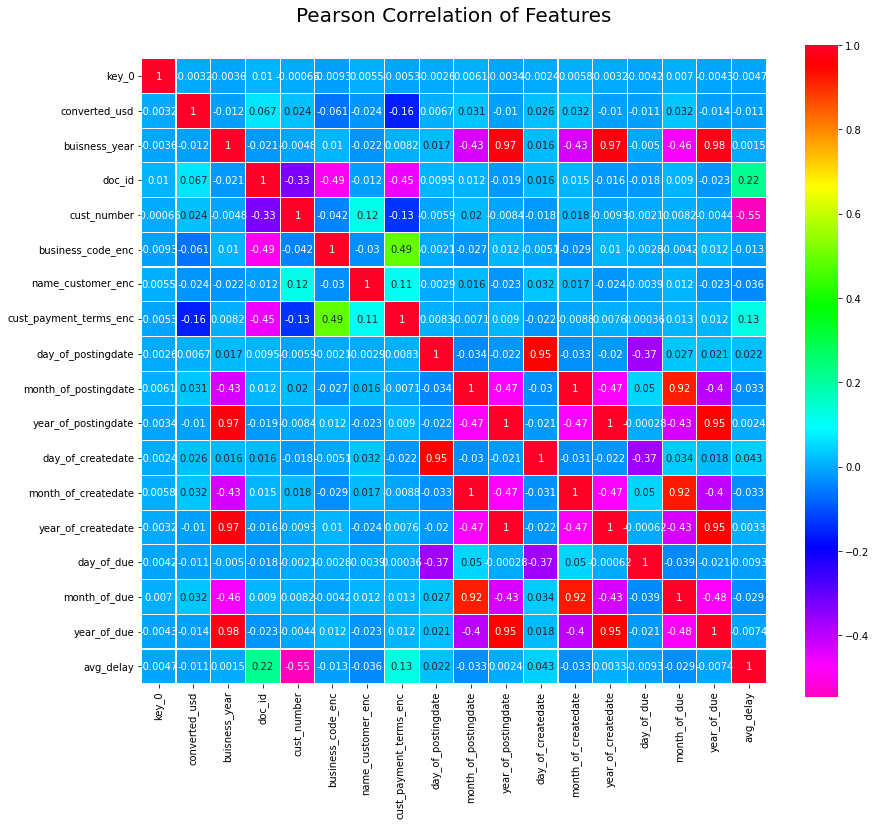

In [724]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=20)
sns.heatmap(X_train.merge(y_train , on = X_train.index ).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap='gist_rainbow_r', linecolor='white', annot=True)

#### Calling variance threshold for threshold value = 0.8

- Note -  Fill in the blanks to call the appropriate method

In [725]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(0.8)
sel.fit(X_train)

VarianceThreshold(threshold=0.8)

In [726]:
sel.variances_

array([1.34173150e+09, 1.14757386e-01, 8.74254278e+16, 1.81954912e+15,
       2.87927752e-01, 1.07015118e+06, 1.35481309e+02, 7.55282009e+01,
       1.22549606e+01, 1.14798749e-01, 7.70243713e+01, 1.22619699e+01,
       1.14937418e-01, 7.66173615e+01, 1.20665594e+01, 1.18125269e-01])

### Features columns are 
- 'year_of_createdate' 
- 'year_of_due'
- 'day_of_createdate'
- 'year_of_postingdate'
- 'month_of_due'
- 'month_of_createdate'

# Modelling 

#### Now you need to compare with different machine learning models, and needs to find out the best predicted model

- Linear Regression
- Decision Tree Regression
- Random Forest Regression
- Support Vector Regression
- Extreme Gradient Boost Regression 

### You need to make different blank list for different evaluation matrix 

- MSE
- R2
- Algorithm

In [727]:
MSE_Score = []
R2_Score = []
Algorithm = []
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### You need to start with the baseline model Linear Regression

- Step 1 : Call the Linear Regression from sklearn library
- Step 2 : make an object of Linear Regression 
- Step 3 : fit the X_train and y_train dataframe into the object 
- Step 4 : Predict the output by passing the X_test Dataset into predict function




- Note - Append the Algorithm name into the algorithm list for tracking purpose

In [728]:
from sklearn.linear_model import LinearRegression
Algorithm.append('LinearRegression')
regressor = LinearRegression()
regressor.fit(X_train, y_train)
predicted= regressor.predict(X_test)

### Check for the 

- Mean Square Error
- R Square Error 

for y_test and predicted dataset and store those data inside respective list for comparison 

In [729]:
MSE_Score.append(mean_squared_error(y_test, predicted))
R2_Score.append(r2_score(y_test, predicted))

### Check the same for the Validation set also 

In [730]:
predict_test= regressor.predict(X_val)
mean_squared_error(y_val, predict_test, squared=False)

521974.1311403552

### Display The Comparison Lists

In [731]:
for i in Algorithm, MSE_Score, R2_Score:
    print(i,end=',')

['LinearRegression'],[289680194603.15015],[0.31983222128121136],

### You need to start with the baseline model Support Vector Regression

- Step 1 : Call the Support Vector Regressor from sklearn library
- Step 2 : make an object of SVR
- Step 3 : fit the X_train and y_train dataframe into the object 
- Step 4 : Predict the output by passing the X_test Dataset into predict function




- Note - Append the Algorithm name into the algorithm list for tracking purpose

In [732]:
from sklearn.svm import SVR
Algorithm.append('Support Vector Regression')
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train, y_train)
predicted= regressor.predict(X_test)

### Check for the 

- Mean Square Error
- R Square Error 

for "y_test" and "predicted" dataset and store those data inside respective list for comparison 

In [733]:
MSE_Score.append(mean_squared_error(y_test, predicted))
R2_Score.append(r2_score(y_test, predicted))

### Check the same for the Validation set also 

In [734]:
predict_test= regressor.predict(X_val)
mean_squared_error(y_val, predict_test, squared=False)

631968.1689215614

### Display The Comparison Lists

In [735]:
for i in Algorithm, MSE_Score, R2_Score:
    print(i,end=',')

['LinearRegression', 'Support Vector Regression'],[289680194603.15015, 427979886589.643],[0.31983222128121136, -0.004894826160928734],

### Your next model would be Decision Tree Regression

- Step 1 : Call the Decision Tree Regressor from sklearn library
- Step 2 : make an object of Decision Tree
- Step 3 : fit the X_train and y_train dataframe into the object 
- Step 4 : Predict the output by passing the X_test Dataset into predict function




- Note - Append the Algorithm name into the algorithm list for tracking purpose

In [736]:
from sklearn.tree import DecisionTreeRegressor 
Algorithm.append('DecisionTreeRegressor')
regressor = DecisionTreeRegressor(random_state = 0) 
regressor.fit(X_train, y_train)
predicted= regressor.predict(X_test)

### Check for the 

- Mean Square Error
- R Square Error 

for y_test and predicted dataset and store those data inside respective list for comparison 

In [737]:
MSE_Score.append(mean_squared_error(y_test, predicted))
R2_Score.append(r2_score(y_test, predicted))

### Check the same for the Validation set also 

In [738]:
predict_test= regressor.predict(X_val)
mean_squared_error(y_val, predict_test, squared=False)

513213.57109250466

### Display The Comparison Lists

In [739]:
for i in Algorithm, MSE_Score, R2_Score:
    print(i,end=',')

['LinearRegression', 'Support Vector Regression', 'DecisionTreeRegressor'],[289680194603.15015, 427979886589.643, 440245664501.1602],[0.31983222128121136, -0.004894826160928734, -0.03369481688091547],

### Your next model would be Random Forest Regression

- Step 1 : Call the Random Forest Regressor from sklearn library
- Step 2 : make an object of Random Forest
- Step 3 : fit the X_train and y_train dataframe into the object 
- Step 4 : Predict the output by passing the X_test Dataset into predict function




- Note - Append the Algorithm name into the algorithm list for tracking purpose

In [740]:
from sklearn.ensemble import RandomForestRegressor
Algorithm.append('Random Forest Regression')
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train, y_train)
predicted= regressor.predict(X_test)

### Check for the 

- Mean Square Error
- R Square Error 

for y_test and predicted dataset and store those data inside respective list for comparison 

In [741]:
MSE_Score.append(mean_squared_error(y_test, predicted))
R2_Score.append(r2_score(y_test, predicted))

### Check the same for the Validation set also 

In [742]:
predict_test= regressor.predict(X_val)
mean_squared_error(y_val, predict_test, squared=False)

337606.01607369265

### Display The Comparison Lists


In [743]:
for i in Algorithm, MSE_Score, R2_Score:
    print(i,end=',')

['LinearRegression', 'Support Vector Regression', 'DecisionTreeRegressor', 'Random Forest Regression'],[289680194603.15015, 427979886589.643, 440245664501.1602, 157254097204.81516],[0.31983222128121136, -0.004894826160928734, -0.03369481688091547, 0.6307680953585479],

### The last but not the least model would be XGBoost or Extreme Gradient Boost Regression

- Step 1 : Call the XGBoost Regressor from xgb library
- Step 2 : make an object of Xgboost
- Step 3 : fit the X_train and y_train dataframe into the object 
- Step 4 : Predict the output by passing the X_test Dataset into predict function




- Note - Append the Algorithm name into the algorithm list for tracking purpose### Extreme Gradient Boost Regression
- Note -  No need to change the code 

In [744]:
import xgboost as xgb
Algorithm.append('XGB Regressor')
regressor = xgb.XGBRegressor()
regressor.fit(X_train, y_train)
predicted = regressor.predict(X_test)

[17:10:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### Check for the 

- Mean Square Error
- R Square Error 

for y_test and predicted dataset and store those data inside respective list for comparison 

In [745]:
MSE_Score.append(mean_squared_error(y_test, predicted))
R2_Score.append(r2_score(y_test, predicted))

### Check the same for the Validation set also 

In [746]:
predict_test= regressor.predict(X_val)
mean_squared_error(y_val, predict_test, squared=False)

376176.2396380941

### Display The Comparison Lists


In [747]:
for i in Algorithm, MSE_Score, R2_Score:
    print(i,end=',')

['LinearRegression', 'Support Vector Regression', 'DecisionTreeRegressor', 'Random Forest Regression', 'XGB Regressor'],[289680194603.15015, 427979886589.643, 440245664501.1602, 157254097204.81516, 155448983110.90723],[0.31983222128121136, -0.004894826160928734, -0.03369481688091547, 0.6307680953585479, 0.6350064950367494],

## You need to make the comparison list into a comparison dataframe 

In [748]:
temp_dict = {
    'Algorithm': Algorithm,
    'MSE_Score': MSE_Score,
    'R2_Score': R2_Score
}
comparison_df = pd.DataFrame(temp_dict)
comparison_df

,Algorithm,MSE_Score,R2_Score
0,LinearRegression,2.896802e+11,0.319832
1,Support Vector Regression,4.279799e+11,-0.004895
2,DecisionTreeRegressor,4.402457e+11,-0.033695
3,Random Forest Regression,1.572541e+11,0.630768
4,XGB Regressor,1.554490e+11,0.635006


## Now from the Comparison table, you need to choose the best fit model

- Step 1 - Fit X_train and y_train inside the model 
- Step 2 - Predict the X_test dataset
- Step 3 - Predict the X_val dataset


- Note - No need to change the code

In [749]:
regressorfinal = xgb.XGBRegressor()
regressorfinal.fit(X_train, y_train)
predictedfinal = regressorfinal.predict(X_test)
predict_testfinal = regressorfinal.predict(X_val)

[17:10:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### Calculate the Mean Square Error for test dataset

- Note - No need to change the code

In [750]:
mean_squared_error(y_test,predictedfinal,squared=False)

394270.19049239217

### Calculate the mean Square Error for validation dataset

In [751]:
mean_squared_error(y_val, predict_testfinal,squared=False)

376176.2396380941

### Calculate the R2 score for test

In [752]:
r2_score(y_test, predictedfinal)

0.6350064950367494

### Calculate the R2 score for Validation

In [753]:
r2_score(y_val, predict_testfinal)

0.6439164805002624

### Calculate the Accuracy for train Dataset 

In [754]:
regressorfinal.score(X_train, y_train)

0.7604403607164213

### Calculate the accuracy for validation

In [755]:
regressorfinal.score(X_val, y_val)

0.6439164805002624

### Calculate the accuracy for test

In [756]:
regressorfinal.score(X_test, y_test)

0.6350064950367494

## Specify the reason behind choosing your machine learning model 

- Note : Provide your answer as a text here

## Now you need to pass the Nulldata dataframe into this machine learning model

#### In order to pass this Nulldata dataframe into the ML model, we need to perform the following

- Step 1 : Label Encoding 
- Step 2 : Day, Month and Year extraction 
- Step 3 : Change all the column data type into int64 or float64
- Step 4 : Need to drop the useless columns 

### Display the Nulldata 

In [757]:
nulldata

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd
3,CA02,0140105686,SYSC llc,NaT,2020.0,2.960623e+09,2020-03-30,2020-04-10,2020-03-31,CA10,2309.79
7,U001,0200744019,TARG us,NaT,2020.0,1.930659e+09,2020-03-19,2020-04-03,2020-03-19,NAA8,11173.02
10,U001,0200418007,AM,NaT,2020.0,1.930611e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,3525.59
14,U001,0200739534,OK systems,NaT,2020.0,1.930788e+09,2020-04-15,2020-04-30,2020-04-15,NAA8,121105.65
15,U001,0200353024,DECA corporation,NaT,2020.0,1.930817e+09,2020-04-23,2020-04-26,2020-04-16,NAM2,3726.06
...,...,...,...,...,...,...,...,...,...,...,...
49975,U001,0200769623,WAL-MAR in,NaT,2020.0,1.930625e+09,2020-03-10,2020-03-25,2020-03-10,NAH4,13114.99
49980,U001,0200769623,WAL-MAR corporation,NaT,2020.0,1.930851e+09,2020-05-03,2020-05-18,2020-05-03,NAH4,8899.71
49982,U001,0200148860,DOLLA co,NaT,2020.0,1.930638e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,4967.06
49992,U001,0200900909,SYSCO co,NaT,2020.0,1.930702e+09,2020-03-25,2020-04-09,2020-03-25,NAA8,1998.64


### Check for the number of rows and columns in the nulldata

In [758]:
nulldata.shape

(9681, 11)

### Check the Description and Information of the nulldata 

In [759]:
display(nulldata.describe())
print()
display(nulldata.info())

,buisness_year,doc_id,converted_usd
count,9681.0,9.681000e+03,9681.000000
mean,2020.0,2.006165e+09,32065.681125
std,0.0,2.673629e+08,35419.613688
min,2020.0,1.930535e+09,0.720000
25%,2020.0,1.930658e+09,5607.190000
50%,2020.0,1.930731e+09,19024.190000
75%,2020.0,1.930818e+09,47752.640000
max,2020.0,2.960636e+09,653644.800000



<class 'pandas.core.frame.DataFrame'>
Int64Index: 9681 entries, 3 to 49995
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   business_code         9681 non-null   object        
 1   cust_number           9681 non-null   object        
 2   name_customer         9681 non-null   object        
 3   clear_date            0 non-null      datetime64[ns]
 4   buisness_year         9681 non-null   float64       
 5   doc_id                9681 non-null   float64       
 6   posting_date          9681 non-null   datetime64[ns]
 7   due_in_date           9681 non-null   datetime64[ns]
 8   baseline_create_date  9681 non-null   datetime64[ns]
 9   cust_payment_terms    9681 non-null   object        
 10  converted_usd         9681 non-null   float64       
dtypes: datetime64[ns](4), float64(3), object(4)
memory usage: 907.6+ KB


None

### Storing the Nulldata into a different dataset 
# for BACKUP

In [760]:
nulldata1 = copy.deepcopy(nulldata)

### Call the Label Encoder for Nulldata

- Note - you are expected to fit "business_code" as it is a categorical variable
- Note - No need to change the code

In [761]:
from sklearn.preprocessing import LabelEncoder
business_codern = LabelEncoder()
business_codern.fit(nulldata['business_code'])
nulldata['business_code_enc'] = business_codern.transform(nulldata['business_code'])

### Now you need to manually replacing str values with numbers
- Note - No need to change the code

In [762]:
nulldata['cust_number'] = nulldata['cust_number'].str.replace('CCCA',"1").str.replace('CCU',"2").str.replace('CC',"3").astype(int)

## You need to extract day, month and year from the "clear_date", "posting_date", "due_in_date", "baseline_create_date" columns


##### 1.   Extract day from "clear_date" column and store it into 'day_of_cleardate'
##### 2.   Extract month from "clear_date" column and store it into 'month_of_cleardate'
##### 3.   Extract year from "clear_date" column and store it into 'year_of_cleardate'



##### 4.   Extract day from "posting_date" column and store it into 'day_of_postingdate'
##### 5.   Extract month from "posting_date" column and store it into 'month_of_postingdate'
##### 6.   Extract year from "posting_date" column and store it into 'year_of_postingdate'




##### 7.   Extract day from "due_in_date" column and store it into 'day_of_due'
##### 8.   Extract month from "due_in_date" column and store it into 'month_of_due'
##### 9.   Extract year from "due_in_date" column and store it into 'year_of_due'




##### 10.   Extract day from "baseline_create_date" column and store it into 'day_of_createdate'
##### 11.   Extract month from "baseline_create_date" column and store it into 'month_of_createdate'
##### 12.   Extract year from "baseline_create_date" column and store it into 'year_of_createdate'




- Note - You are supposed To use - 

*   dt.day
*   dt.month
*   dt.year

In [763]:
nulldata['day_of_cleardate'] = nulldata['clear_date'].dt.day
nulldata['month_of_cleardate'] = nulldata['clear_date'].dt.month
nulldata['year_of_cleardate'] = nulldata['clear_date'].dt.year

nulldata['day_of_postingdate'] = nulldata['posting_date'].dt.day
nulldata['month_of_postingdate'] = nulldata['posting_date'].dt.month
nulldata['year_of_postingdate'] = nulldata['posting_date'].dt.year

nulldata['day_of_due'] = nulldata['due_in_date'].dt.day
nulldata['month_of_due'] = nulldata['due_in_date'].dt.month
nulldata['year_of_due'] = nulldata['due_in_date'].dt.year

nulldata['day_of_createdate'] = nulldata['baseline_create_date'].dt.day
nulldata['month_of_createdate'] = nulldata['baseline_create_date'].dt.month
nulldata['year_of_createdate'] = nulldata['baseline_create_date'].dt.year

### Use Label Encoder1 of all the following columns - 
- 'cust_payment_terms' and store into 'cust_payment_terms_enc'
- 'business_code' and store into 'business_code_enc'
- 'name_customer' and store into 'name_customer_enc'

Note - No need to change the code

In [764]:
nulldata['cust_payment_terms_enc']=label_encoder1.transform(nulldata['cust_payment_terms'])
nulldata['business_code_enc']=label_encoder1.transform(nulldata['business_code'])
nulldata['name_customer_enc']=label_encoder.transform(nulldata['name_customer'])

### Check for the datatypes of all the columns of Nulldata

In [765]:
nulldata.dtypes

business_code                     object
cust_number                        int64
name_customer                     object
clear_date                datetime64[ns]
buisness_year                    float64
doc_id                           float64
posting_date              datetime64[ns]
due_in_date               datetime64[ns]
baseline_create_date      datetime64[ns]
cust_payment_terms                object
converted_usd                    float64
business_code_enc                  int64
day_of_cleardate                 float64
month_of_cleardate               float64
year_of_cleardate                float64
day_of_postingdate                 int64
month_of_postingdate               int64
year_of_postingdate                int64
day_of_due                         int64
month_of_due                       int64
year_of_due                        int64
day_of_createdate                  int64
month_of_createdate                int64
year_of_createdate                 int64
cust_payment_ter

### Now you need to drop all the unnecessary columns - 

- 'business_code'
- "baseline_create_date"
- "due_in_date"
- "posting_date"
- "name_customer"
- "clear_date"
- "cust_payment_terms"
- 'day_of_cleardate'
- "month_of_cleardate"
- "year_of_cleardate"

In [766]:
columns_to_remove = [
                     'business_code', "baseline_create_date", "due_in_date", "posting_date",
                     "name_customer", "clear_date", "cust_payment_terms", 'day_of_cleardate', "month_of_cleardate", "year_of_cleardate"
          ]
          
nulldata.drop(columns_to_remove, axis = 1, inplace = True)

### Check the information of the "nulldata" dataframe

In [767]:
nulldata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9681 entries, 3 to 49995
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cust_number             9681 non-null   int64  
 1   buisness_year           9681 non-null   float64
 2   doc_id                  9681 non-null   float64
 3   converted_usd           9681 non-null   float64
 4   business_code_enc       9681 non-null   int64  
 5   day_of_postingdate      9681 non-null   int64  
 6   month_of_postingdate    9681 non-null   int64  
 7   year_of_postingdate     9681 non-null   int64  
 8   day_of_due              9681 non-null   int64  
 9   month_of_due            9681 non-null   int64  
 10  year_of_due             9681 non-null   int64  
 11  day_of_createdate       9681 non-null   int64  
 12  month_of_createdate     9681 non-null   int64  
 13  year_of_createdate      9681 non-null   int64  
 14  cust_payment_terms_enc  9681 non-null  

### Compare "nulldata" with the "X_test" dataframe 

- use info() method

In [768]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7832 entries, 23619 to 5096
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   converted_usd           7832 non-null   float64
 1   buisness_year           7832 non-null   float64
 2   doc_id                  7832 non-null   float64
 3   cust_number             7832 non-null   int64  
 4   business_code_enc       7832 non-null   int64  
 5   name_customer_enc       7832 non-null   int64  
 6   cust_payment_terms_enc  7832 non-null   int64  
 7   day_of_postingdate      7832 non-null   int64  
 8   month_of_postingdate    7832 non-null   int64  
 9   year_of_postingdate     7832 non-null   int64  
 10  day_of_createdate       7832 non-null   int64  
 11  month_of_createdate     7832 non-null   int64  
 12  year_of_createdate      7832 non-null   int64  
 13  day_of_due              7832 non-null   int64  
 14  month_of_due            7832 non-nul

### You must have noticed that there is a mismatch in the column sequence while compairing the dataframes

- Note - In order to fed into the machine learning model, you need to edit the sequence of "nulldata", similar to the "X_test" dataframe

- Display all the columns of the X_test dataframe 
- Display all the columns of the Nulldata dataframe 
- Store the Nulldata with new sequence into a new dataframe 


- Note - The code is given below, no need to change 

In [769]:
X_test.columns

Index(['converted_usd', 'buisness_year', 'doc_id', 'cust_number',
       'business_code_enc', 'name_customer_enc', 'cust_payment_terms_enc',
       'day_of_postingdate', 'month_of_postingdate', 'year_of_postingdate',
       'day_of_createdate', 'month_of_createdate', 'year_of_createdate',
       'day_of_due', 'month_of_due', 'year_of_due'],
      dtype='object')

In [770]:
nulldata.columns

Index(['cust_number', 'buisness_year', 'doc_id', 'converted_usd',
       'business_code_enc', 'day_of_postingdate', 'month_of_postingdate',
       'year_of_postingdate', 'day_of_due', 'month_of_due', 'year_of_due',
       'day_of_createdate', 'month_of_createdate', 'year_of_createdate',
       'cust_payment_terms_enc', 'name_customer_enc'],
      dtype='object')

In [771]:
nulldata2=nulldata[['cust_number', 'buisness_year', 'doc_id', 'converted_usd',
       'business_code_enc', 'name_customer_enc', 'cust_payment_terms_enc',
       'day_of_postingdate', 'month_of_postingdate', 'year_of_postingdate',
       'day_of_createdate', 'month_of_createdate', 'year_of_createdate',
       'day_of_due', 'month_of_due', 'year_of_due']]

### Display the Final Dataset

In [772]:
nulldata2

,cust_number,buisness_year,doc_id,converted_usd,business_code_enc,name_customer_enc,cust_payment_terms_enc,day_of_postingdate,month_of_postingdate,year_of_postingdate,day_of_createdate,month_of_createdate,year_of_createdate,day_of_due,month_of_due,year_of_due
3,140105686,2020.0,2.960623e+09,2309.79,66,2714,5,30,3,2020,31,3,2020,10,4,2020
7,200744019,2020.0,1.930659e+09,11173.02,66,2798,18,19,3,2020,19,3,2020,3,4,2020
10,200418007,2020.0,1.930611e+09,3525.59,66,89,18,11,3,2020,11,3,2020,26,3,2020
14,200739534,2020.0,1.930788e+09,121105.65,66,2043,18,15,4,2020,15,4,2020,30,4,2020
15,200353024,2020.0,1.930817e+09,3726.06,66,733,34,23,4,2020,16,4,2020,26,4,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49975,200769623,2020.0,1.930625e+09,13114.99,66,3001,32,10,3,2020,10,3,2020,25,3,2020
49980,200769623,2020.0,1.930851e+09,8899.71,66,2999,32,3,5,2020,3,5,2020,18,5,2020
49982,200148860,2020.0,1.930638e+09,4967.06,66,811,18,11,3,2020,11,3,2020,26,3,2020
49992,200900909,2020.0,1.930702e+09,1998.64,66,2761,18,25,3,2020,25,3,2020,9,4,2020


### Now you can pass this dataset into you final model and store it into "final_result"

In [773]:
nulldata2 = nulldata[X_train.columns]
final_result = regressorfinal.predict(nulldata2)

### you need to make the final_result as dataframe, with a column name "avg_delay"

- Note - No need to change the code

In [774]:
final_result = pd.Series(final_result,name='avg_delay')

### Display the "avg_delay" column

In [775]:
final_result

0       7.832753e+05
1       2.977819e+05
2       1.588351e+06
3       1.096266e+05
4      -3.107997e+05
            ...     
9676    1.478427e+05
9677    1.478427e+05
9678   -2.187737e+05
9679    1.629177e+05
9680   -8.833120e+03
Name: avg_delay, Length: 9681, dtype: float32

### Now you need to merge this final_result dataframe with the BACKUP of "nulldata" Dataframe which we have created in earlier steps

In [776]:
nulldata1.reset_index(drop=True,inplace=True)
Final = nulldata1.merge(final_result , on = nulldata.index )

### Display the "Final" dataframe 

In [777]:
Final

,key_0,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd,avg_delay
0,3,CA02,0140105686,SYSC llc,NaT,2020.0,2.960623e+09,2020-03-30,2020-04-10,2020-03-31,CA10,2309.79,7.832753e+05
1,7,U001,0200744019,TARG us,NaT,2020.0,1.930659e+09,2020-03-19,2020-04-03,2020-03-19,NAA8,11173.02,2.977819e+05
2,10,U001,0200418007,AM,NaT,2020.0,1.930611e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,3525.59,1.588351e+06
3,14,U001,0200739534,OK systems,NaT,2020.0,1.930788e+09,2020-04-15,2020-04-30,2020-04-15,NAA8,121105.65,1.096266e+05
4,15,U001,0200353024,DECA corporation,NaT,2020.0,1.930817e+09,2020-04-23,2020-04-26,2020-04-16,NAM2,3726.06,-3.107997e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9676,49975,U001,0200769623,WAL-MAR in,NaT,2020.0,1.930625e+09,2020-03-10,2020-03-25,2020-03-10,NAH4,13114.99,1.478427e+05
9677,49980,U001,0200769623,WAL-MAR corporation,NaT,2020.0,1.930851e+09,2020-05-03,2020-05-18,2020-05-03,NAH4,8899.71,1.478427e+05
9678,49982,U001,0200148860,DOLLA co,NaT,2020.0,1.930638e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,4967.06,-2.187737e+05
9679,49992,U001,0200900909,SYSCO co,NaT,2020.0,1.930702e+09,2020-03-25,2020-04-09,2020-03-25,NAA8,1998.64,1.629177e+05


### Check for the Number of Rows and Columns in your "Final" dataframe 

In [778]:
Final.shape

(9681, 13)

### Now, you need to do convert the below fields back into date and time format 

- Convert "due_in_date" into datetime format
- Convert "avg_delay" into datetime format
- Create a new column "clear_date" and store the sum of "due_in_date" and "avg_delay"
- display the new "clear_date" column
- Note - Code is given below, no need to change 

In [779]:
Final['clear_date'] = pd.to_datetime(Final['due_in_date']) + pd.to_timedelta(Final['avg_delay'], unit='s')

### Display the "clear_date" column

In [780]:
Final['clear_date'] 

0      2020-04-19 01:34:35.312500000
1      2020-04-06 10:43:01.875000000
2      2020-04-13 09:12:31.250000000
3      2020-05-01 06:27:06.640625000
4      2020-04-22 09:40:00.281250000
                    ...             
9676   2020-03-26 17:04:02.656250000
9677   2020-05-19 17:04:02.656250000
9678   2020-03-23 11:13:46.281250000
9679   2020-04-10 21:15:17.718750000
9680   2020-05-05 21:32:46.879882812
Name: clear_date, Length: 9681, dtype: datetime64[ns]

### Convert the average delay into number of days format 

- Note - Formula = avg_delay//(24 * 3600)
- Note - full code is given for this, no need to change 

In [781]:
Final['avg_delay'] = Final.apply(lambda row: row.avg_delay//(24 * 3600), axis = 1)

### Display the "avg_delay" column 

In [782]:
Final['avg_delay'] 

0        9.0
1        3.0
2       18.0
3        1.0
4       -4.0
        ... 
9676     1.0
9677     1.0
9678    -3.0
9679     1.0
9680    -1.0
Name: avg_delay, Length: 9681, dtype: float64

### Now you need to convert average delay column into bucket

- Need to perform binning 
- create a list of bins i.e. bins= [0,15,30,45,60,100]
- create a list of labels i.e. labels = ['0-15','16-30','31-45','46-60','Greatar than 60']
- perform binning by using cut() function from "Final" dataframe


- Please fill up the first two rows of the code

In [783]:
bins= [0,15,30,45,60,100]
labels = ['0-15','16-30','31-45','46-60','Greatar than 60']
Final['Aging Bucket'] = pd.cut(Final['avg_delay'], bins=bins, labels=labels, right=False)

### Now you need to drop "key_0" and "avg_delay" columns from the "Final" Dataframe

In [784]:
columns_to_remove = ['key_0', 'avg_delay']
Final.drop(columns_to_remove, axis=1, inplace=True)

### Display the count of each categoty of new "Aging Bucket" column 

In [785]:
Final['Aging Bucket'].value_counts()

0-15               7694
16-30               142
31-45                76
46-60                 6
Greatar than 60       3
Name: Aging Bucket, dtype: int64

### Display your final dataset with aging buckets 

In [786]:
Final

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,due_in_date,baseline_create_date,cust_payment_terms,converted_usd,Aging Bucket
0,CA02,0140105686,SYSC llc,2020-04-19 01:34:35.312500000,2020.0,2.960623e+09,2020-03-30,2020-04-10,2020-03-31,CA10,2309.79,0-15
1,U001,0200744019,TARG us,2020-04-06 10:43:01.875000000,2020.0,1.930659e+09,2020-03-19,2020-04-03,2020-03-19,NAA8,11173.02,0-15
2,U001,0200418007,AM,2020-04-13 09:12:31.250000000,2020.0,1.930611e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,3525.59,16-30
3,U001,0200739534,OK systems,2020-05-01 06:27:06.640625000,2020.0,1.930788e+09,2020-04-15,2020-04-30,2020-04-15,NAA8,121105.65,0-15
4,U001,0200353024,DECA corporation,2020-04-22 09:40:00.281250000,2020.0,1.930817e+09,2020-04-23,2020-04-26,2020-04-16,NAM2,3726.06,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
9676,U001,0200769623,WAL-MAR in,2020-03-26 17:04:02.656250000,2020.0,1.930625e+09,2020-03-10,2020-03-25,2020-03-10,NAH4,13114.99,0-15
9677,U001,0200769623,WAL-MAR corporation,2020-05-19 17:04:02.656250000,2020.0,1.930851e+09,2020-05-03,2020-05-18,2020-05-03,NAH4,8899.71,0-15
9678,U001,0200148860,DOLLA co,2020-03-23 11:13:46.281250000,2020.0,1.930638e+09,2020-03-11,2020-03-26,2020-03-11,NAA8,4967.06,NaN
9679,U001,0200900909,SYSCO co,2020-04-10 21:15:17.718750000,2020.0,1.930702e+09,2020-03-25,2020-04-09,2020-03-25,NAA8,1998.64,0-15


### Store this dataframe into the .csv format

In [787]:
Final.to_csv('Final.csv')

# END OF THE PROJECT